# Lab 1: Pytorch and Generalized Linear Models
We'll use Python and [PyTorch](https://pytorch.org/) for the labs in this course.

For the PyTorch section, it will introduce:
- **Tensors**: PyTorch's equivalent of NumPy arrays, but with more bells and whistles for running on GPUs and supporting automatic differentiation.
- **Broadcasting and Fancy Indexing**: If you're coming from Matlab or NumPy, you probably know that you can avoid costly for-loops by broadcasting computation over dimensions of an array (here, tensor) and using fancy indexing tricks.
- **Distributions**: PyTorch has an excellent library of distributions for sampling, evaluating log probabilities, and much more.

For the Generalized Linear Models (GLMs) section, you'll build GLMs of retinal ganglion cell (RGC) responses to visual stimuli. You'll use PyTorch to implement the models and fit them to a dataset in the "Deep Retina" paper [(McIntosh et al, 2017)](https://arxiv.org/abs/1702.01825).

**References:**

McIntosh, Lane T., Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. “Deep Learning Models of the Retinal Response to Natural Scenes.” Advances in Neural Information Processing (NeurIPS), 2017.

In [1]:
using_colab = False

In [2]:
if using_colab:
    # install some required python packages
    !pip3 install neo elephant --quiet
    import sys
    from google.colab import drive
    drive.mount('/content/gdrive/')
    sys.path.append('/content/gdrive/MyDrive/lab1/')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np

import h5py
import matplotlib.pyplot as plt
import seaborn as sns

from utils import train_model, plot_stimulus_weights

# Specify that we want our tensors on the CPU/GPU and in float32
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

c:\Users\omarh\Documents\GaTech\BMED8813\lab1\lab1\utils.py:182: SyntaxWarning: invalid escape sequence '\D'
  axs[n, 0].set_xlabel("$\Delta t$ [ms]")
c:\Users\omarh\Documents\GaTech\BMED8813\lab1\lab1\utils.py:451: SyntaxWarning: invalid escape sequence '\s'
  label="$X \star W$")
c:\Users\omarh\Documents\GaTech\BMED8813\lab1\lab1\utils.py:472: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title("data $\mathbb{E}[X]$")
c:\Users\omarh\Documents\GaTech\BMED8813\lab1\lab1\utils.py:668: SyntaxWarning: invalid escape sequence '\s'
  """Deconvolve a noisy calcium trace (aka "target") by solving a


## Pytorch Primer

### Constructing Tensors

Tensors are PyTorch's equivalent of NumPy arrays. The PyTorch documentation already has a [great tutorial](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html) on tensors.

Once you've read through that, try using torch functions like `arange`, `reshape`, etc. to construct the following tensors.

### Problem 1

Construct the following tensor:

```
tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])
```

_Note: For this problems and the ones below, don't literally construct the tensor from the specified list. Use torch functions._

---

In [4]:
tensor = torch.arange(9)
tensor = tensor.reshape(3, 3)
print(tensor)

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [5]:
# TEST YOUR ANSWER
assert tensor.shape == (3,3)

### Problem 2

Construct the following tensor:

```
tensor([[0, 3, 6],
        [1, 4, 7],
        [2, 5, 8]])
```

---

In [6]:
tensor = torch.arange(9)
tensor = tensor.reshape(3, 3)
tensor = tensor.t()
print(tensor)

tensor([[0, 3, 6],
        [1, 4, 7],
        [2, 5, 8]])


In [7]:
# TEST YOUR ANSWER
assert tensor.shape == (3,3)

### Problem 3

Construct the following tensor:

```
tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])
```

_Note: Here the sequence is repeated 3 times. Does your code support arbitrary numbers of repeats?_

---

In [8]:
tensor = torch.arange(5).tile(3)
print(tensor)

tensor([0, 1, 2, 3, 4, 0, 1, 2, 3, 4, 0, 1, 2, 3, 4])


In [9]:
# TEST YOUR ANSWER
assert tensor.shape == (15,)

### Broadcasting and Fancy Indexing

Your code will be much faster once you get the hang of broadcasting and indexing. Start by reading the  [PyTorch documentation](https://pytorch.org/docs/stable/notes/broadcasting.html).

### Problem 1

Construct a tensor `X` where `X[i,j] = i + j` by broadcasting a sum of two 1-dimensional tensors.

For example, broadcast a sum to construct the following tensor,

```
tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])
```        

---

In [10]:
# tensor_1 = ...
# tensor_2 = ...
# tensor = tensor_1 + tensor_2
# YOUR CODE HERE
tensor_1 = torch.arange(4).reshape(4,1)
tensor_2 = torch.arange(3).reshape(1,3)
tensor = tensor_1 + tensor_2
print(tensor_1,"\n", tensor_2, "\n", tensor)

tensor([[0],
        [1],
        [2],
        [3]]) 
 tensor([[0, 1, 2]]) 
 tensor([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])


In [11]:
# TEST YOUR ANSWER
assert (tensor == torch.tensor([[0, 1, 2],[1, 2, 3],[2, 3, 4],[3, 4, 5]])).all()

### Problem 2

Extract the submatrix of rows `[2,3]` and columns `[0,1,4]` of the tensor,
```
A = torch.arange(25).reshape(5, 5)
```

Your answer should be,
```
tensor([[10, 11, 14],
        [15, 16, 19]])
```

---

In [12]:
A = torch.arange(25).reshape(5, 5)
# A = ...
# YOUR CODE HERE
tensor = torch.index_select(A, 0, torch.tensor([2,3]))
tensor = torch.index_select(tensor, 1, torch.tensor([0,1,4]))
print(tensor)

tensor([[10, 11, 14],
        [15, 16, 19]])


In [13]:
# TEST YOUR ANSWER
assert (tensor == torch.tensor([[10, 11, 14], [15, 16, 19]])).all()

### Problem 3

Create a binary mask matrix `M` of the same shape as `A` where `M[i,j]` is True if and only if `A[i,j]` is divisible by 7. Let

```
A = torch.arange(25).reshape(5, 5)
```

Your answer should be

```
tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False,  True, False, False, False]])
```

---

In [14]:
A = torch.arange(25).reshape(5, 5)
# tensor = ...
# YOUR CODE HERE
tensor = (A % 7 == 0)
print(tensor)

tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False,  True, False, False, False]])


In [15]:
# TEST YOUR ANSWER
assert (tensor == torch.tensor([[ True, False, False, False, False],
        [False, False,  True, False, False],
        [False, False, False, False,  True],
        [False, False, False, False, False],
        [False,  True, False, False, False]])).all()

### Distributions

PyTorch has an excellent library of distributions in `torch.distributions`. Read the docs [here](https://pytorch.org/docs/stable/distributions.html).

We will use these distribution objects to construct and fit a Poisson mixture model.

### Problem 1

Draw 50 samples from a Poisson distribution with rate 10.

---

In [16]:
# rates = ...
# poisson = torch.distributions.poisson.Poisson(...)
# samples = ...
# YOUR CODE HERE
rate = 10
poisson = torch.distributions.poisson.Poisson(rate)
samples = poisson.sample((50,))
print(samples)

tensor([12., 10., 13., 11., 14.,  2.,  7.,  7.,  7., 16., 10.,  9., 19., 12.,
         7.,  7., 17., 18., 12., 13., 14., 11., 16., 10.,  6., 13.,  8., 11.,
        12., 14.,  7.,  9., 20., 11., 10., 11.,  7.,  8., 10., 11.,  9.,  9.,
         8., 11., 10., 12.,  6.,  9.,  7., 13.])


In [17]:
# TEST YOUR ANSWER
assert samples.shape == (50,)

### Problem 2

Evaluate the log probability of the points `[1.5, 3., 4.2]` under a gamma distribution with shape (aka concentration) 2.0 and inverse scale (aka rate) 1.5.

Your answer should be,

```
tensor([-1.0336, -2.5905, -4.0540])
```

---

In [18]:
gamma = torch.distributions.gamma.Gamma(concentration=2, rate=1.5)
points = torch.tensor([1.5, 3, 4.2])
log_prob = gamma.log_prob(points)
print(log_prob)

tensor([-1.0336, -2.5905, -4.0540])


In [19]:
# TEST YOUR ANSWER
assert (log_prob == gamma.log_prob(torch.Tensor([1.5, 3.0, 4.2]))).all()

### Problem 3

One of the awesome thing about PyTorch distributions is that they support broadcasting too.

Construct a matrix `P` where `P[i,j]` equals $\mathrm{Pois}(x=j; \lambda=i)$ for $i=0,\ldots,4$ and $j=0,\ldots,4$.

Your answer should be,
```
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3679, 0.3679, 0.1839, 0.0613, 0.0153],
        [0.1353, 0.2707, 0.2707, 0.1804, 0.0902],
        [0.0498, 0.1494, 0.2240, 0.2240, 0.1680],
        [0.0183, 0.0733, 0.1465, 0.1954, 0.1954]])
```

---

In [20]:
rates = torch.arange(5).reshape(5,1)
x_vals = torch.arange(5).reshape(1,5)
poisson = torch.distributions.poisson.Poisson(rates)
log_probs = poisson.log_prob(x_vals)
probs = torch.exp(log_probs)
print(probs)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3679, 0.3679, 0.1839, 0.0613, 0.0153],
        [0.1353, 0.2707, 0.2707, 0.1804, 0.0902],
        [0.0498, 0.1494, 0.2240, 0.2240, 0.1680],
        [0.0183, 0.0733, 0.1465, 0.1954, 0.1954]])


In [21]:
# TEST YOUR ANSWER
assert probs.shape == (5,5)

## Generalized Linear Models

### Load the neural data


Load the data from the HDF5 file.
- Each file contains a `train` and `test` group.
- Each group contains:
    - `time`: length `frames` array of timestamps
    - `stimulus`: a `frames x 50 x 50` video taken at ~100Hz
    - `response`: a group with
        - `binned`: `cells x frames` array of spike counts (for the training data) or rates (for the test data) in each bin
        - `firing_rate_xms` where `x` is 5, 10, or 20 milliseconds



In [22]:
# Load the white noise data
if using_colab:
    f = h5py.File("/content/gdrive/MyDrive/lab1/data/whitenoise.h5", mode='r')
else:
    f = h5py.File("./data/whitenoise.h5", mode='r')
frame_rate = 100
times = torch.tensor(f['train']['time'][:], dtype=dtype)
stimulus = torch.tensor(f['train']['stimulus'][:], dtype=torch.uint8)
spikes = torch.tensor(f['train']['response']['binned'][:].T, dtype=dtype)
test_times = torch.tensor(f['test']['time'][:], dtype=dtype)
test_stimulus = torch.tensor(f['test']['stimulus'][:], dtype=torch.uint8)
test_rates = torch.tensor(f['test']['response']['binned'][:, :-1].T, dtype=dtype)

# Get the size of the training data
num_frames, height, width = stimulus.shape
_, num_neurons = spikes.shape

### Plot a Slice of the Spike Train

Always visualize your data first!

Write a function to `imshow` a slice of the data.
Add a colorbar and label your axes!

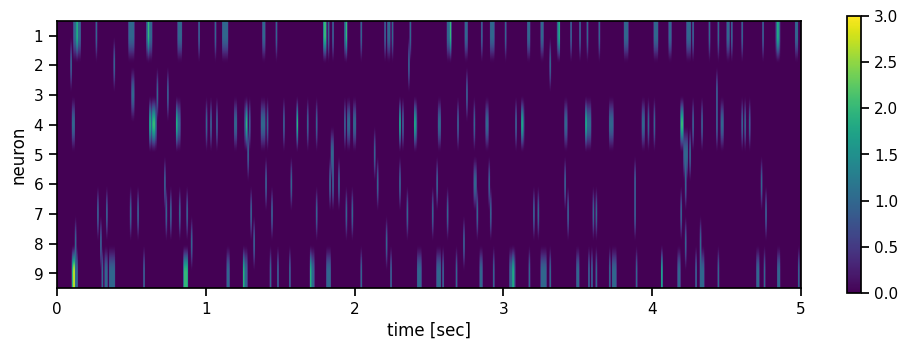

In [23]:
# Plot a few seconds of the spike train
def plot_spike_train(spikes, t_start, t_stop, figsize=(12, 6)):
    """
    `imshow` a window of the spike count matrix.

    spikes:  time x neuron spike count matrix
    t_start: time (in seconds) of the start of the window
    t_stop:  time (in seconds) of the end of the window
    figsize: width and height of the figure in inches
    """
    plt.figure(figsize=figsize)

    plt.imshow(spikes[t_start*frame_rate:t_stop*frame_rate, :].T, aspect=20)
    plt.colorbar(shrink=0.6)
    plt.ylabel("neuron")
    plt.yticks(np.arange(0,9), np.arange(1,10))

    plt.xlabel("time [sec]")
    plt.xticks(np.arange(0,(t_stop-t_start+1)*frame_rate, frame_rate), np.arange(0,6))

plot_spike_train(spikes, 0, 5)

### Plot a Few Frames of the Stimulus

Plot the 0th, 10th, 20th, and 30th frames of stimulus in grayscale.

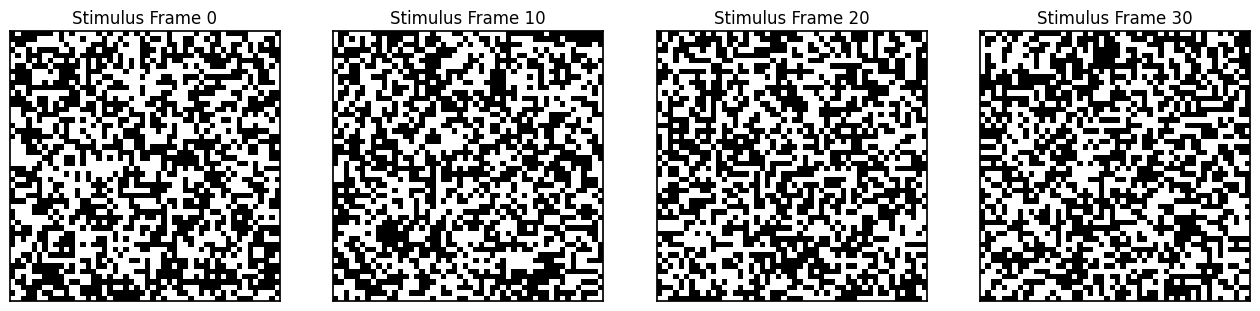

In [24]:
# Plot a few frames of stimulus
def plot_stimulus(stimulus, frame_inds, n_cols=4, panel_size=4):
    num_frames = len(frame_inds)
    n_rows = int(torch.ceil(torch.tensor(num_frames / n_cols)))
    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * panel_size, n_rows * panel_size))
    for ax, ind in zip(axs.ravel(), frame_inds):
        ax.imshow(stimulus[ind], cmap="Greys")
        ax.set_title("Stimulus Frame {}".format(ind))
        ax.set_xticks([])
        ax.set_yticks([])
    for ax in axs.ravel()[len(frame_inds):]:
        ax.set_visible(False)

plot_stimulus(stimulus, [0, 10, 20, 30])


### Create PyTorch Datasets Containing the Stimuli and the Spikes.
We split the training stimulus and spikes into batches of length 1000 frames (10 seconds of data). Then we'll randomly assign 20% of the batches to a validation dataset. We've written a simple dataset to get the training and validation batches. For stability, we normalize the stimulus to be binary rather than 0 or 128, as in the raw data.

In [25]:
class RGCDataset(Dataset):
    def __init__(self, stimulus, spikes):
        self.stimulus = stimulus
        self.spikes = spikes

    def __len__(self):
        return self.stimulus.shape[0]

    def __getitem__(self, idx):
        # Binarize the stimulus, move it and the spikes to the GPU,
        # and package into a dictionary
        x = self.stimulus[idx].to(device).type(dtype) / 128.0
        y = self.spikes[idx].to(device)
        return dict(stimulus=x, spikes=y)

def make_datasets(batch_size=1000):
    n_batches = num_frames // batch_size
    batched_stimulus = stimulus[:n_batches * batch_size]
    batched_stimulus = batched_stimulus.reshape(n_batches, batch_size, height, width)
    batched_spikes = spikes[:n_batches * batch_size]
    batched_spikes = batched_spikes.reshape(n_batches, batch_size, num_neurons)

    # Split into train and validation
    torch.manual_seed(0)
    n_train = int(0.8 * n_batches)
    order = torch.randperm(n_batches)
    train_stimulus = batched_stimulus[:n_train]
    val_stimulus = batched_stimulus[n_train:]
    train_spikes = batched_spikes[:n_train]
    val_spikes = batched_spikes[n_train:]

    train_dataset = RGCDataset(train_stimulus, train_spikes)
    val_dataset = RGCDataset(val_stimulus, val_spikes)
    return train_dataset, val_dataset

train_dataset, val_dataset = make_datasets()

### What is a GLM ?

---

Let's start with a simple generalized linear model (GLM). GLMs are natural models for count data, like spike counts. Whereas standard linear models could ouput negative means, these models are constrained to output non-negative expected spike counts. Moreover, since they use a Poisson noise model, the variance of the spike counts will grow with the mean, unlike in typical linear regression models.

The basic GLM is,

$$
\begin{aligned}
\widetilde{y}_{t,n} &= f \left(\sum_{d=1}^D \sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} w_{n,d,i,j} \right)
\end{aligned}
$$

where $\widetilde{y}_{t,n}$ is the prediceted spike firing rate for neuron $n$ at time $t$, $\mathbf{X} \in \mathbb{R}^{D \times P_h \times P_W}$ are the stimulus where entry $x_{d,i,j}$ is the simulus at pixel $i,j$ at $d$ frames, and $\mathbf{W}_n \in \mathbb{R}^{D \times P_h \times P_W}$ are the weights where entry $w_{n,d,i,j}$ is the weight neuron $n$ gives to the simulus at pixel $i,j$ at $d$ frames preceding the current time.

Assume the weights factor into a **spatial footprint** $\mathbf{u}_n \in \mathbb{R}^{P_H \times P_W}$ times a **temporal profile** $\mathbf{v}_n \in \mathbb{R}^D$.

$$
w_{n,d,i,j} = v_{n,d} u_{n,i,j}
$$

Then the prediceted spike firing rate can be written as,

$$
\begin{aligned}
\widetilde{y}_{t,n} &= f \left( \sum_{d=1}^D v_{n,d} \left(\sum_{i=1}^{P_H} \sum_{j=1}^{P_W} x_{t-d,i,j} u_{n,i,j} \right) \right) \\
&= f \left( \sum_{d=1}^D v_{n,d} \tilde{x}_{n,t-d} \right) \\
&= f \left( a_{t,n} \right)
\end{aligned}
$$

where

$$
a_{t,n} = [\tilde{\mathbf{x}}_n \star \mathbf{v}_n]_t
$$

is the **activation** of neuron $n$ at time $t$. The activation is a cross-correlation (convolution in PyTorch) between $\tilde{\mathbf{x}}_{n} \in \mathbb{R}^T$, the stimulus projected onto the spatial filter for neuron $n$, and $\mathbf{v}_n$, the temporal profile for neuron $n$. The mean function $f: \mathbb{R} \to \mathbb{R}_+$ maps activation to a non-negative expected spike count.

Once we compute $\widetilde{y}_{t,n}=f ( a_{t,n} )$, we then compute the likelihood function based on a Poisson regression model:

$$
\begin{aligned}
\log p(y_{t,n}; \mathbf{X} \mathbf{W}_n) &= \mathrm{Po}(y_{t,n}; f ( a_{t,n} )) \\
&= \log f( a_{t,n})- f ( a_{t,n} ) - \log(y_{t,n}!)
\\ & = y_{t,n} a_{t,n}- \exp ( a_{t,n} ) - \log(y_{t,n}!)
\end{aligned}
$$

where $y_{t,n}$ is the spike counts for neuron $n$ at time $t$ and $f(a) = e^a$.

Summing across samples in $t$ leads to the full likelihood for estimating the parameters for a given neuron. We can do this simultaneously across all neurons by summing over $n$ too, as gradient descent will independently update each neuron's parameters.

---

### Implement the GLM

Let's start by implementing the GLM model as a class that inherits from `nn.Module`. The  `forward` method returns the mean spike count for each time bin
given the stimulus. In the loss function below, we'll pass this output to the mean of a Poisson distribution.

**Notes:**
- You should first project the stimulus onto the spatial filters with a linear layer, then you can convolve with the temporal filters.
- Even though the spatial projection is a linear layer, we'll call it `spatial_conv` since its a factor of a spatiotemporal convolution. This naming will also be consistent with our models below.
- Both `spatial_conv` and `temporal_conv` include a learnable bias, by default. We only need one, so turn off the bias in the spatial layer.
- `mean_function` specifies the mapping from the linear predictor to the expected spike count. We'll use an exponential function to be consistent with the lecture, but `F.softplus` is more common in practice. (It tends to be a little more stable during training.
- We set the initial bias to a value that is roughly the log of the average spike count so that our initial means are in the right ballpark.
- We'll add a small positive constant to the firing rate in the `forward` function to ensure that we don't get `log(0)` errors during training.


You'll use the `torch.nn.Conv1d` object, which implements a convolutional layer for a neural network.  Take a look at its documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

**Remember that `Conv1d` actually performs a cross-correlation!**

Let $\mathbf{A} \in \mathbb{R}^{B \times K \times T}$ denote the signal/input and $\mathbf{J} \in \mathbb{R}^{N \times K \times D}$ denote the filter/weights, and let $\mathbf{G} \in \mathbb{R}^{B \times N \times T - D + 1}$ denote the output. Then the `Conv1d` implements the cross-correlation,

$$
\begin{align*}
g_{b,n,t} = \sum_{k = 1}^{K} \sum_{d=1}^D a_{b,k,t+d-1} j_{n,k,d}.
\end{align*}
$$

for $b=1,\ldots,B$, $n=1,\ldots,N$, and $t=1,\ldots,T-D+1$.

By default the output only contains the "valid" portion of the convolution; i.e. the $T-D+1$ samples where the inputs and weights completely overlap. If you want the "full" output, you have to add `padding=D-1`. This pads the input with $D-1$ zeros at the beginning and end so that the resulting output is length $T + D - 1$. Depending your application, you may want the first $T$ or the last $T$ entries in this array.

In [26]:
class GLM(nn.Module):
    def __init__(self,
                 num_neurons=num_neurons,
                 height=height,
                 width=width,
                 max_delay=40,
                 mean_function=torch.exp,
                 initial_bias=0.05):
        super(GLM, self).__init__()
        self.num_neurons = num_neurons
        self.height = height
        self.width = width
        self.max_delay = max_delay
        self.mean_function = mean_function

        ###
        # self.spatial_conv = nn.Linear(in_features=..., out_features=..., bias=...)
        # self.temporal_conv = nn.Conv1d(in_channels=..., out_channels=..., kernel_size=..., groups=..., padding=...)
        # YOUR CODE HERE
        self.spatial_conv = nn.Linear(in_features=height*width,
                                      out_features=num_neurons,
                                      bias=False)
        self.temporal_conv = nn.Conv1d(in_channels=1,
                                       out_channels=num_neurons,
                                       kernel_size=max_delay,
                                       groups=1,
                                       padding=max_delay-1)
        ###

        # Initialize the bias
        torch.nn.init.constant_(self.temporal_conv.bias,
                                torch.log(torch.tensor(initial_bias)))

    def forward(self, stimulus):
        """
        stimulus: num_frames x height x width

        returns: num_frames x num_neurons tensor of expected spike counts
        """
        x = stimulus

        ###
        # x_tilde = self.spatial_conv(...) # num_frames x num_neurons
        # a = self.temporal_conv(...).T # num_frames x num_neurons
        # YOUR CODE HERE
        x = x.view(x.shape[0], -1)
        x_tilde = self.spatial_conv(x).unsqueeze(1)
        a = self.temporal_conv(x_tilde).mT
        rate = self.mean_function(a)
        ###

        return 1e-4 + rate

In [27]:
# TEST YOUR ANSWER
torch.manual_seed(0)
glm = GLM().to(device)
output = glm(torch.randn(train_dataset[0]['stimulus'].shape).to(device))


### Implement the Poisson Loss
Compute the average negative log likelihood of the spikes (taking the mean over neurons and frames) given the expected spike counts (`rates`) ouput by the model.

$$
\begin{aligned}
\mathcal{L}(\mathbf{W}) = -\frac{1}{NT} \sum_{n=1}^N \sum_{t=1}^T \log \mathrm{Po}(y_{t,n} \mid f(a_{t,n}))
\end{aligned}
$$


In [28]:
def poisson_loss(rate, spikes):
    """Compute the log-likelihood under a Poisson spiking model.

    rate:  T x N array of expected spike counts
    spikes: T x N array of integer spikes
    returns: average negative log likelihood (mean over all spikes)
    """
    ###
    # poisson = torch.distributions.poisson.Poisson(...)
    # avg_nll = ...
    # YOUR CODE HERE
    rate = rate.unsqueeze(2)
    poisson = torch.distributions.poisson.Poisson(rate)
    log_probs = poisson.log_prob(spikes)
    nll = -log_probs
    avg_nll = nll.mean()
    ###

    return avg_nll

In [29]:
# TEST YOUR ANSWER
avg_nll = poisson_loss(glm(train_dataset[0]['stimulus']), train_dataset[0]['spikes'])
print(avg_nll)

tensor(0.2632, device='cuda:0', grad_fn=<MeanBackward0>)


### Add $\ell_2$ Weight Regularization

To the Poisson loss above, we'll add a regularization penalty on the squared $\ell_2$ norm of the weights,

$$
\begin{aligned}
\mathcal{R}(\mathbf{W}) &= \frac{\alpha}{2} \sum_{n=1}^N (\|\mathbf{u}_n\|_F^2 + \|\mathbf{v}_n\|_F^2)
\end{aligned}
$$

where $\mathbf{u}_n$ and $\mathbf{v}_n$ are the spatial and temporal weights for neuron $n$, respectively, and $\alpha$ is a scaling factor.

Do not regularize the biases.


In [30]:
def glm_regularizer(model, alpha=1e-3):
    """Compute the log prior probability under a mean-zero Gaussian model.

    model: GLM instance
    scale: standard deviation
    returns: scalar sum of log probabilities for each spike.
    """
    ###
    # reg = ...
    # YOUR CODE HERE
    reg = 0.0

    spatial_weights = model.spatial_conv.weight
    temporal_weights = model.temporal_conv.weight

    spatial_l2_norm = torch.sum(spatial_weights ** 2)
    temporal_l2_norm = torch.sum(temporal_weights ** 2)

    reg = (alpha / 2) * (spatial_l2_norm + temporal_l2_norm)
    ###

    return reg

### Fit the GLM !

In [31]:
# Construct an GLM with random initial weights.
torch.manual_seed(0)
glm = GLM().to(device)

# Fit the GLM
print("Training GLM...")
train_losses, val_losses = \
    train_model(glm,
                train_dataset,
                val_dataset,
                poisson_loss,
                glm_regularizer)

Training GLM...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

In [32]:
# TEST YOUR ANSWER
print(train_losses[-1], val_losses[-1])

tensor(0.1297) tensor(0.1102)


### Plot the Results

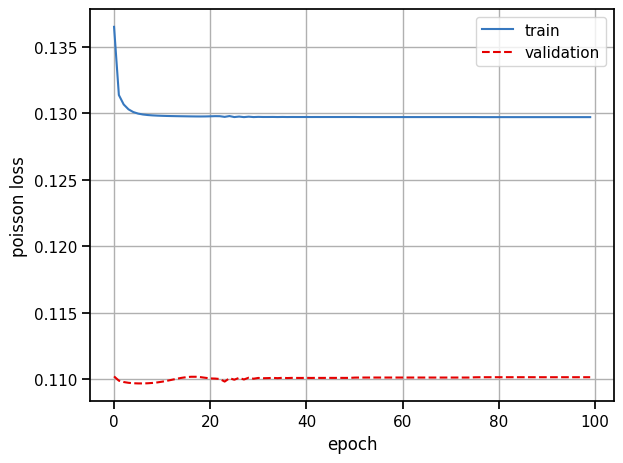

In [33]:
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])


# Plot the training and validation curves
plt.plot(train_losses, color=palette[0], label="train")
plt.plot(val_losses, color=palette[1], ls='--', label="validation")
plt.xlabel("epoch")
plt.ylabel("poisson loss")
plt.grid(True)
plt.legend(loc="upper right")

plt.tight_layout()

### How do we interpret the temporal and spatial weights?

NotImplementedError: 

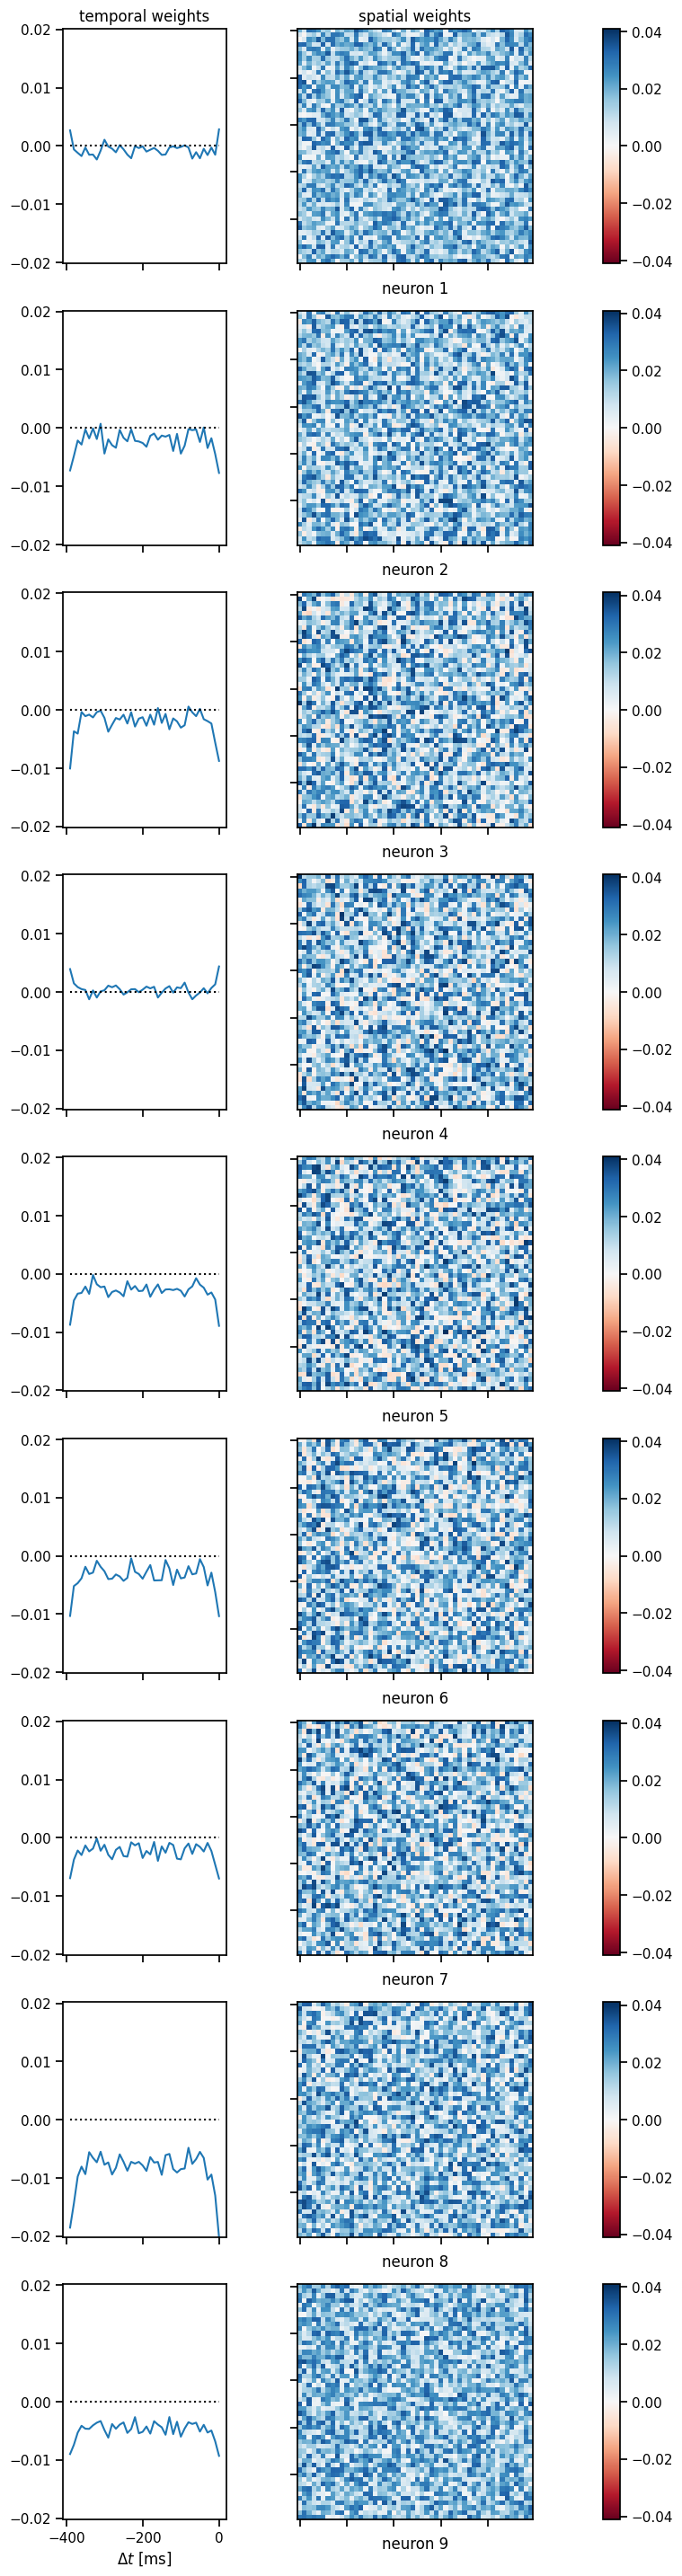

In [34]:
plot_stimulus_weights(glm)

## Explain the meaning of temporal and spatial weights here:
'''
It seems that the temporal weights seem to hover around the 0 mark for the most part, which indicates that these neurons may not have a strong time-based bias or reliance on specific moments
in time for its activations. Most of these weights seem to slightly lean towards the negative values, as opposed to neurons 1 and 4 which are leaning towards the more positive values. Nonetheless,
they all hover around zero. This is to be expected with white noise -- no significant deviations from the baseline and minimal temporal structure. Overall, this means that no timepoints are more
significant than others in terms of influence on the weights.

The spatial weights don't seem to have much discernable features across their individual dimensions. It appears that there are varying levels of responsiveness to specific spatial features,
and no clear structured pattern. This implies that the neuron's activations are influenced by random spatial features rather than specific dimensional attributes. This makes sesnse, as white
noise wouldn't support any clear structural pattern in terms of its spatial dimensionality -- it would be random.
'''

# YOUR CODE HERE
